In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

def generate_adjacency_matrix(N):
    # n_genes = 10
    a = np.random.randint(0, 3, (N, N))
    a[np.tril_indices(a.shape[0], -1)] = a.T[np.tril_indices(a.shape[0], -1)]
    b = np.fliplr(a)
    b[np.tril_indices(b.shape[0], -1)] = b.T[np.tril_indices(a.shape[0], -1)]

    b[b == 2] = -1
    np.fill_diagonal(b, 0)  # Remove self loops
    return b

def get_vector_that_provides_corr(rho, x1):
    n = x1.shape[0]  # length of vector, the number of samples for the same gene that we define in n_cols
    # ho = 0.6  # desired correlation = cos(angle)
    theta = math.acos(rho)  # corresponding angle
    x2 = np.random.normal(2, 0.5, n)  # new random data
    X = np.c_[x1, x2]  # matrix
    Xctr = pd.DataFrame(X).apply(lambda x: x - x.mean()).to_numpy()  # centered columns (mean 0)
    Id = np.diag(np.repeat(1, n))  # identity matrix
    Q = np.linalg.qr(Xctr[:, 0].reshape(n, 1))[0].flatten()  # QR-decomposition, just matrix Q
    P = np.outer(Q, Q)  # projection onto space defined by x1
    x2o = np.dot((Id - P), Xctr[:, 1])  # x2ctr made orthogonal to x1ctr
    Xc2 = np.c_[Xctr[:, 0], x2o]  # bind to matrix
    Y = np.dot(Xc2, np.diag(1 / np.sqrt(np.sum(np.power(Xc2, 2), axis=0))))  # scale columns to length 1
    x = Y[:, 1] + (1 / np.tan(theta)) * Y[:, 0]
    x_norm = (x - x.mean()) / (x.std())
    return x_norm


def simulate_expression_from_adjacency(adjamat, n_samples=100, simdata_noise=0.1):
    # noise = 0.5 # .1 strong correlation, 3 weak correlation
    # random initialize data matrix
    # n_samples = 40 # number of samples: 40 so we later split into 20 cases and 20 controls
    n_rows = adjamat.shape[0]  # number of genes
    mu, sigma = 1, 1  # mean and standard deviation
    dataset = np.random.normal(mu, sigma, n_samples * n_rows).reshape(n_rows, n_samples)
    already_modified = np.repeat(0, n_rows)  # N=n1+n2 genes
    already_modified[0] = 1  # leave the first gene alone, base case

    for i in range(adjamat.shape[1]):
        for j in range(i + 1, adjamat.shape[1]):
            # print(f'Considering row: {i}, column: {j} of A')
            if (adjamat[i, j] == 1) & (already_modified[j] == 0):
                # print(i,j)
                # print(A[i,j])
                dataset[j, :] = dataset[i, :] +  np.random.normal(0, simdata_noise, dataset.shape[1])
                already_modified[j] = 1
            elif (adjamat[i, j] == -1) & (already_modified[j] == 0):
                # print(i,j)
                # print(A[i,j])
                dataset[j, :] = -dataset[i, :] + np.random.normal(0, simdata_noise, dataset.shape[1])
                already_modified[j] = 1
            elif (already_modified[j] == 1) & (already_modified[i] == 0):
                #if j is  modified, we accordingly modify i. If i has been modified, we do nothing.
                dataset[i,:] = dataset[j,:] + np.random.normal(0, simdata_noise, dataset.shape[1])
                already_modified[i] = 1
    ds = pd.DataFrame(dataset)
    ds.columns = 'sample_' + ds.columns.astype(str)
    ds.index = 'gene_' + ds.index.astype(str)
    return ds

def ground_truth_from_adjamat(adjamat):
    genenames = ['gene_' + s for s in list(str(i) for i in range(n_genes))]

    gene_A = []
    gene_B = []
    rels = []
    for i in range(adjamat.shape[1]):
        for j in range(i + 1, adjamat.shape[1]):
            if adjamat[i][j] != 0:
                #print(i, j, adjamat[i, j])
                gene_A.append(i)
                gene_B.append(j)
                rels.append(np.where(adjamat[i, j] > 0, "[+]", "[-]"))

    pairs = pd.DataFrame({'gene_A': gene_A, 'gene_B': gene_B, 'correlation': rels})
    mygenedict = dict(zip(range(adjamat.shape[1]), genenames))
    pairs.gene_A = pairs.gene_A.map(mygenedict)
    pairs.gene_B = pairs.gene_B.map(mygenedict)
    return pairs

Write random matrix of dimensions n_rows (genes) x n_samples (columns)

In [7]:
n_samples = 25
n_rows = 1000
mu, sigma = 1, 1  # mean and standard deviation
genenames = ['sample_' + s for s in list(str(i) for i in range(n_samples))]
print(genenames,sep=" ")

print('Writing random distribution of genes')
with open ('dataset_1000_25.csv', 'a+') as f:
    f.write('gene,'+str(genenames)+'\n')
    for row in tqdm(range(n_rows)):
        #print(row)
        vector = np.random.normal(mu, sigma, n_samples * 1)
        f.write(",".join(str(x) for x in vector)+'\n')
    f.close()

['sample_0', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7', 'sample_8', 'sample_9', 'sample_10', 'sample_11', 'sample_12', 'sample_13', 'sample_14', 'sample_15', 'sample_16', 'sample_17', 'sample_18', 'sample_19', 'sample_20', 'sample_21', 'sample_22', 'sample_23', 'sample_24'] Writing random distribution of genes


100%|██████████| 1000/1000 [00:00<00:00, 25327.77it/s]


Generate co-expresion

[[ 0  1 -1  0  1  0 -1 -1 -1 -1]
 [ 1  0  0 -1  0 -1  1  1 -1 -1]
 [-1  0  0 -1  1  1 -1 -1  1 -1]
 [ 0 -1 -1  0  1  1  0 -1  1 -1]
 [ 1  0  1  1  0  1  1  1 -1  0]
 [ 0 -1  1  1  1  0  1  1  0  1]
 [-1  1 -1  0  1  1  0 -1 -1  0]
 [-1  1 -1 -1  1  1 -1  0  0 -1]
 [-1 -1  1  1 -1  0 -1  0  0  1]
 [-1 -1 -1 -1  0  1  0 -1  1  0]]
        sample_0  sample_1  sample_2  sample_3  sample_4  sample_5  sample_6  \
gene_0  2.328109  1.595606  1.604537  0.567283 -1.149528  0.689494  2.469029   
gene_1  3.649705  1.965412  2.480272  0.453677 -1.235652  0.366235  3.927364   
gene_2 -2.796483 -3.379403 -0.772559 -1.084380  1.778738 -1.176358 -3.813423   
gene_3 -4.194263 -2.698615 -2.987884  0.174241  2.290939 -1.404236 -4.190875   
gene_4  2.118637  3.652088  1.235348  0.483300 -1.309213  1.437647  1.781329   

        sample_7  sample_8  sample_9  ...  sample_40  sample_41  sample_42  \
gene_0  0.644195  1.085666  0.480111  ...   1.003602   1.921016   1.573083   
gene_1 -1.103038  3.002254 -0.68

<AxesSubplot:>

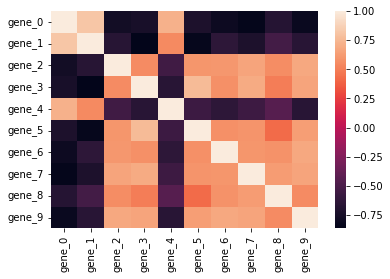

In [9]:
n_genes = 10
adjamat = generate_adjacency_matrix(N=n_genes)
print(adjamat)
ds = simulate_expression_from_adjacency(adjamat=adjamat, n_samples=50, simdata_noise=0.8)
groundtruth = ground_truth_from_adjamat(adjamat)
#ds.to_csv('dataset_'+ str(n_genes) + '.csv')
print(ds.head())
print(groundtruth)
sns.heatmap(ds.T.corr())